

This note book is an exercise based on the Kaggle dataset Climate Change: Earth Surface Temperature Data. The raw data comes from the Berkeley Earth data page. Here I use 'LandAverageTemperature' from the dataset Global Land and Ocean-and-Land Temperatures (GlobalTemperatures.csv):

    Date: starts in 1750 for average land temperature and 1850 for max and min land temperatures and global ocean and land temperatures
    LandAverageTemperature: global average land temperature in celsius
    LandAverageTemperatureUncertainty: the 95% confidence interval around the average
    LandMaxTemperature: global average maximum land temperature in celsius
    LandMaxTemperatureUncertainty: the 95% confidence interval around the maximum land temperature
    LandMinTemperature: global average minimum land temperature in celsius
    LandMinTemperatureUncertainty: the 95% confidence interval around the minimum land temperature
    LandAndOceanAverageTemperature: global average land and ocean temperature in celsius
    LandAndOceanAverageTemperatureUncertainty: the 95% confidence interval around the global average land and ocean temperature



In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats

%matplotlib inline

global_temp = pd.read_csv('GlobalTemperatures.csv')

In [48]:
global_temp['dt'] = pd.to_datetime(global_temp['dt'])
global_temp.set_index('dt', inplace = True)
global_temp.dropna(how = 'any', inplace = True)
global_temp.head()

,LandAverageTemperature,LandAverageTemperatureUncertainty,LandMaxTemperature,LandMaxTemperatureUncertainty,LandMinTemperature,LandMinTemperatureUncertainty,LandAndOceanAverageTemperature,LandAndOceanAverageTemperatureUncertainty
dt,,,,,,,,
1850-01-01,0.749,1.105,8.242,1.738,-3.206,2.822,12.833,0.367
1850-02-01,3.071,1.275,9.970,3.007,-2.291,1.623,13.588,0.414
1850-03-01,4.954,0.955,10.347,2.401,-1.905,1.410,14.043,0.341
1850-04-01,7.217,0.665,12.934,1.004,1.018,1.329,14.667,0.267
1850-05-01,10.004,0.617,15.655,2.406,3.811,1.347,15.507,0.249


In [49]:
global_temp['LandAverageTemperature'].tail()

dt
2015-08-01    14.755
2015-09-01    12.999
2015-10-01    10.801
2015-11-01     7.433
2015-12-01     5.518
Name: LandAverageTemperature, dtype: float64

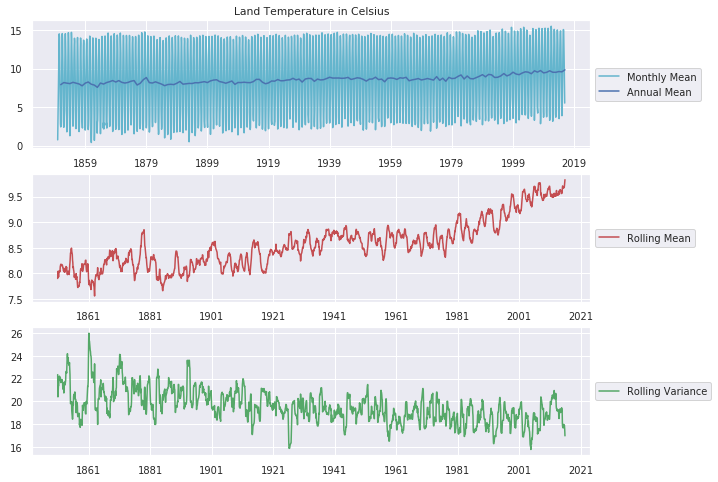

Results of Dickey-Fuller Test on Monthly Mean:
Test Statistic                   -1.455328
p-value                           0.555483
#Lags Used                       26.000000
Number of Observations Used    1965.000000
Critical Value (1%)              -3.433682
Critical Value (5%)              -2.863012
Critical Value (10%)             -2.567554
dtype: float64


In [51]:
fig = plt.figure(figsize = (10, 8))
plt.subplot(311)
plt.title('Land Temperature in Celsius')
plt.plot(global_temp['LandAverageTemperature'], color = 'c', label = 'Monthly Mean')
plt.plot(global_temp['LandAverageTemperature'].resample('A').mean(), color = 'b', label = 'Annual Mean')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))



# Adding rolling mean
rolmean = global_temp['LandAverageTemperature'].rolling(window=12).mean()
rolvar = global_temp['LandAverageTemperature'].rolling( window=12).var()

plt.subplot(312)
plt.plot(rolmean, label = 'Rolling Mean', color = 'r')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(313)
plt.plot(rolvar, label = 'Rolling Variance', color = 'g')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

# Augmented Dickey-Fuller Test for stationarity.
def stationarity_test(s, name = None):
    if name != None:
        print('Results of Dickey-Fuller Test on %s:'%name)
    else:
        print('Results of Dickey-Fuller Test:')
    
    df_test = sm.tsa.stattools.adfuller(s)
    df_result = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_result['Critical Value (%s)'%key] = value
    print(df_result)

stationarity_test(global_temp['LandAverageTemperature'], 'Monthly Mean')

<Figure size 720x720 with 0 Axes>

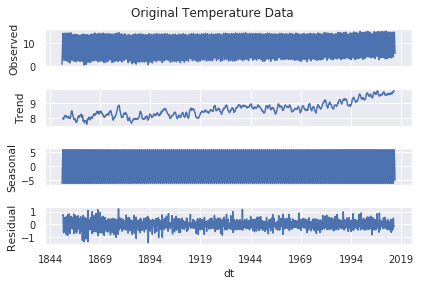

In [52]:
decomposition = sm.tsa.seasonal_decompose(global_temp['LandAverageTemperature'], model='additive')  
fig = plt.figure(figsize = (10, 10))  
fig = decomposition.plot()
plt.suptitle('Original Temperature Data')
fig.tight_layout()
fig.subplots_adjust(top = 0.9)




This data is not stationary. It has an upward trend and strong seasonality. Thus I will first attempt to remove seasonality. As seen below, a seasonal (12 months) difference alone makes the stationarity test statistic smaller than the 1% critical values.


In [54]:


temp_diff12 = global_temp['LandAverageTemperature'] - global_temp['LandAverageTemperature'].shift(12)
temp_diff12.dropna(inplace = True)
stationarity_test(temp_diff12, 'Temperature - 12 Month Difference')


Results of Dickey-Fuller Test on Temperature - 12 Month Difference:
Test Statistic                -1.278337e+01
p-value                        7.334162e-24
#Lags Used                     2.400000e+01
Number of Observations Used    1.955000e+03
Critical Value (1%)           -3.433699e+00
Critical Value (5%)           -2.863020e+00
Critical Value (10%)          -2.567558e+00
dtype: float64


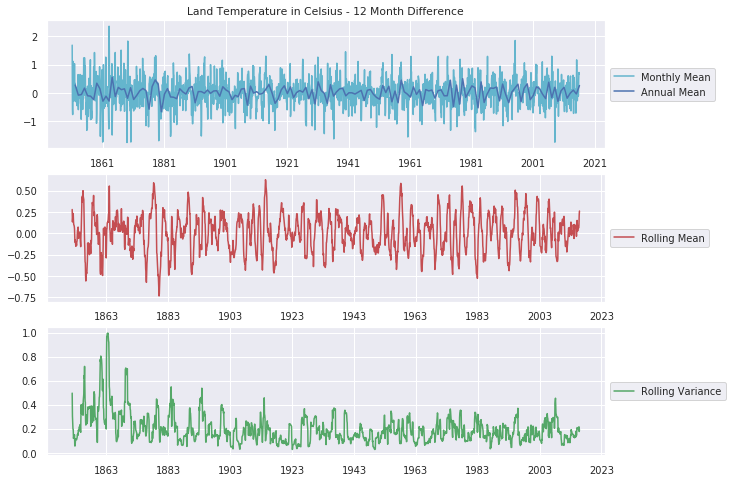

In [55]:
fig = plt.figure(figsize = (10, 8))

plt.subplot(311)
plt.title('Land Temperature in Celsius - 12 Month Difference')
plt.plot(temp_diff12, color = 'c', label = 'Monthly Mean')
plt.plot(temp_diff12.resample('A').mean(), color = 'b', label = 'Annual Mean')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Adding rolling mean
rolmean = temp_diff12.rolling(window=12).mean()
rolvar = temp_diff12.rolling(window=12).var()

plt.subplot(312)
plt.plot(rolmean, label = 'Rolling Mean', color = 'r')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplot(313)
plt.plot(rolvar, label = 'Rolling Variance', color = 'g')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()



Modeling the Data (Seasonal ARIMA)



The autoregressive integrated moving average (ARIMA) model is a model often used for analyzing time series data. In this notebook, I will try to use an ARIMA model to model the temperature data above, and use the model to predict the temperatures within and out of the time range of this historical data.

I start by examining the ACF and PACF plots of the seasonal differentiated data:


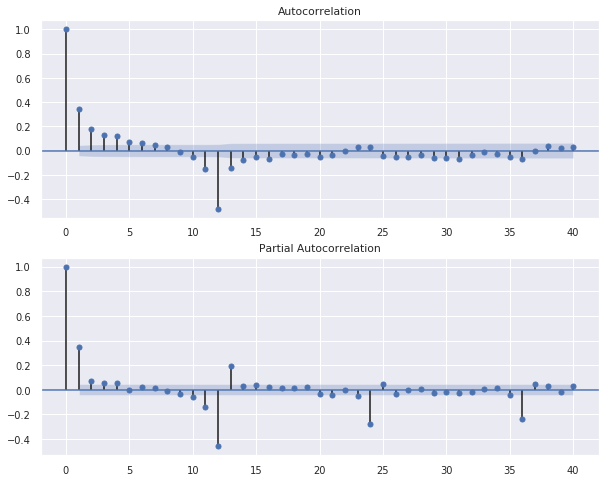

In [57]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(temp_diff12, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(temp_diff12, lags=40, ax=ax2)



The seasonal part of the model has a MA(1) term, since there is a spike at lag 12 in the ACF but no other significant spikes, and the PACF shows exponential decay at lag 12x. The non-seasonal part has a AR(2) term, but the MA term is less obvious. After experimenting with the non-seasonal MA term below, I decided the ARIMA(2,0,2)(0,1,1)12 gives the best results. (The experimenting code is commentted out in order to save some run time of this notebook.)


In [60]:
mod000 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(0,0,0), 
                                   seasonal_order=(0,1,1,12), enforce_stationarity = False, 
                                   enforce_invertibility = False).fit()

mod201 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(2,0,1), 
                                   seasonal_order=(0,1,1,12), enforce_stationarity = False, 
                                   enforce_invertibility = False).fit()


mod202 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(2,0,2), 
                                   seasonal_order=(0,1,1,12), enforce_stationarity = False, 
                                   enforce_invertibility = False).fit()


mod205 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order=(2,0,5), 
                                   seasonal_order=(0,1,1,12), enforce_stationarity = False, 
                                   enforce_invertibility = False).fit()

print('Model', 'AIC', 'BIC', 'HQIC')
for i in range(4):
    mods = [mod000, mod201, mod202, mod205]
    mod_names = ['(0,0,0)', '(2,0,1)', '(2,0,2)', '(2,0,5)']    
    print('ARIMA' + mod_names[i] + 'x(0,1,1)_12', mods[i].aic, mods[i].bic, mods[i].hqic)


/home/harshi/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



Model AIC BIC HQIC
ARIMA(0,0,0)x(0,1,1)_12 1718.8843462712125 1730.0528759079907 1722.9886490007311
ARIMA(2,0,1)x(0,1,1)_12 1258.3336400208098 1286.2524215243452 1268.5937263317182
ARIMA(2,0,2)x(0,1,1)_12 1249.7045523566514 1283.2040375024717 1262.0158508509116
ARIMA(2,0,5)x(0,1,1)_12 1259.4698773470593 1309.705354108187 1277.933198055829


In [62]:
mod202 = sm.tsa.statespace.SARIMAX(global_temp['LandAverageTemperature'], order = (2, 0, 2), 
                                   seasonal_order=(0,1,1,12), enforce_stationarity = False, 
                                   enforce_invertibility = False).fit()
print('Model', 'AIC', 'BIC', 'HQIC')
print('ARIMA(2,0,2)x(0,1,1)_12', mod202.aic, mod202.bic, mod202.hqic)

Model AIC BIC HQIC
ARIMA(2,0,2)x(0,1,1)_12 1249.704550888028 1283.2040360338483 1262.0158493822883


In [68]:
print(mod202.summary())

                                 Statespace Model Results                                 
Dep. Variable:             LandAverageTemperature   No. Observations:                 1992
Model:             SARIMAX(2, 0, 2)x(0, 1, 1, 12)   Log Likelihood                -618.852
Date:                            Tue, 02 Jul 2019   AIC                           1249.705
Time:                                    15:54:20   BIC                           1283.204
Sample:                                01-01-1850   HQIC                          1262.016
                                     - 12-01-2015                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.5563      0.055     28.133      0.000       1.448       1.665
ar.L2         -0.5575      0.055   

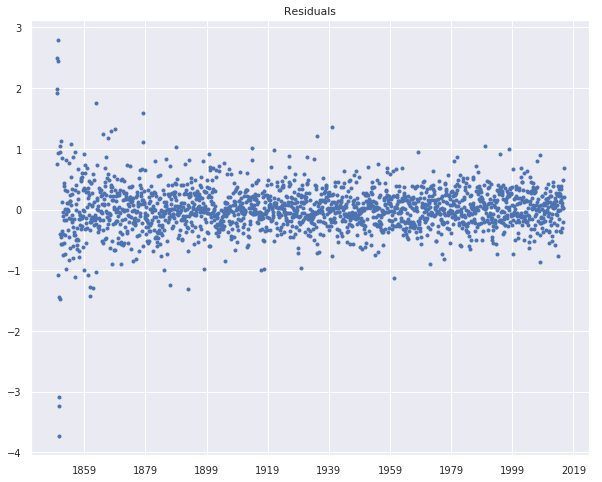

In [69]:
fig = plt.figure(figsize = (10, 8))
resid202 = mod202.resid
plt.plot(resid202, 'b.')
plt.title('Residuals')
plt.show()

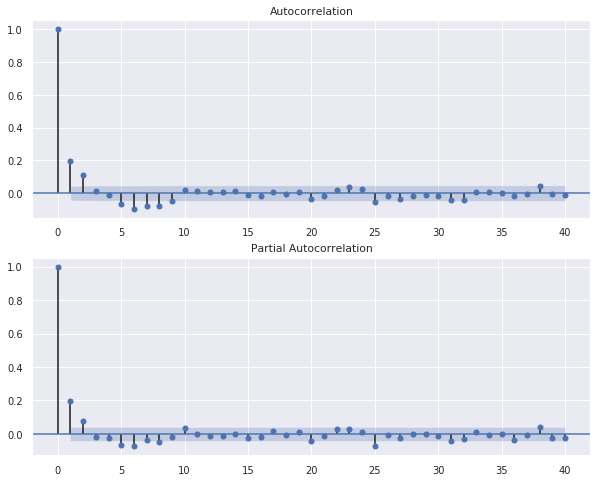

In [70]:
fig = plt.figure(figsize = (10, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(resid202, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(resid202, lags=40, ax=ax2)



Neither the ACF or PACF plots of the residuals showed any spikes beside lag 0, indicating the residuals are not autocorrelated.

For the normal test below, the H0 is that a sample comes from a normal distribution.


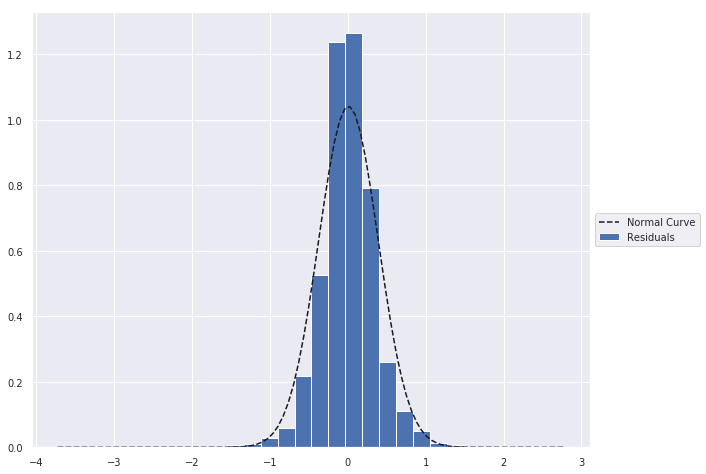

NormaltestResult(statistic=463.7759499276343, pvalue=1.9603429424634064e-101)


In [71]:
def fit_norm(data):
    '''Fits a Normal distribution to 1D data.'''
    mu, std = stats.norm.fit(data)
    x = np.linspace(np.min(data),np.max(data),100)
    y = stats.norm.pdf(x, mu, std)
    return (x, y)


plt.figure(figsize = (10, 8))
plt.hist(resid202, bins = 30, normed = True, label = 'Residuals')
x, y = fit_norm(resid202)
plt.plot(x, y,'k--', label = 'Normal Curve')
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

print(stats.normaltest(resid202))

<Figure size 720x576 with 0 Axes>

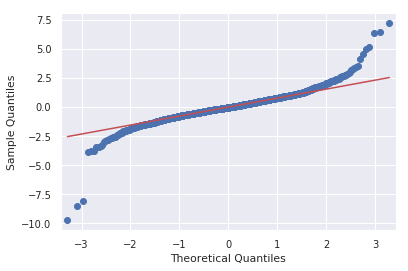

In [72]:
fig = plt.figure(figsize = (10, 8))
ax = sm.graphics.qqplot(resid202, line='q', fit=True)



From the normal test and the Q-Q plot, we can see the residuals are heavy tailed.



Making Predictions

I have used this ARIMA(2,0,2)x(0,1,1)_12 model from above to make in-sample and out-of-sample predictions. The date of last entry in the historical data is 2015-12-01. We will make a five year prediction afterwards only for the sake of learning. Of courese in reality, five-year-ahead weather prediction is almost guaranteed unrealiable.


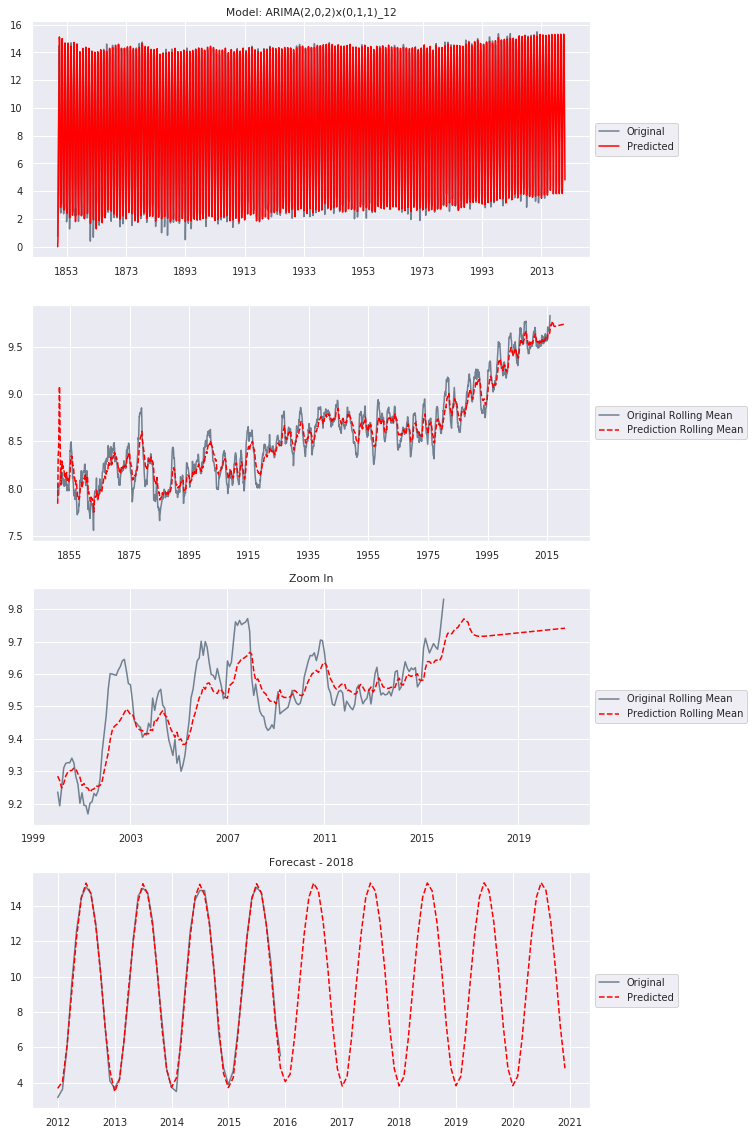

In [75]:
predict_mod202 = mod202.predict('1850-01-01', '2020-12-01')

fig, axs = plt.subplots(4, figsize = (10, 20))
axs[0].set_title('Model: ARIMA(2,0,2)x(0,1,1)_12')
axs[0].plot(global_temp['LandAverageTemperature'], color = 'slategray', label = 'Original')
axs[0].plot(predict_mod202, color = 'red', label = 'Predicted')
axs[0].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


predict_rolmean = predict_mod202.rolling(window=12).mean()
original_rolmean = global_temp['LandAverageTemperature'].rolling(window=12).mean()

axs[1].plot(original_rolmean, color = 'slategray', label = 'Original Rolling Mean')
axs[1].plot(predict_rolmean, color = 'red', linestyle = '--', label='Prediction Rolling Mean')
axs[1].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

axs[2].set_title('Zoom In')
axs[2].plot(original_rolmean['2000':], color = 'slategray', label = 'Original Rolling Mean')
axs[2].plot(predict_rolmean['2000':], color = 'red', linestyle = '--', label='Prediction Rolling Mean')
axs[2].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

axs[3].set_title('Forecast - 2018')
axs[3].plot(global_temp['LandAverageTemperature']['2012':'2020'], color = 'slategray', label = 'Original')
axs[3].plot(predict_mod202['2012':'2020'], color='red', linestyle = '--', label = 'Predicted')
axs[3].legend(loc='center left', bbox_to_anchor=(1.0, 0.5))


Baseline Comparison

Now I have a working model, I would like to see how it compares against some baseline models. Nate Silver mentions in his book "The Signal and the Noise" with respect to weather forecasting:

"There are two basic tests that any weather forecast must pass to demonstrate its merit:

    It must do better than what meteorologists call persistence: the assumption that the weather will be the same tomorrow (and the next day) as it was today.
    It must also beat climatology, the long-term historical average of conditions on a particular date in a particular area."

Thus I will build these two baseline models accordingly for comparison.



Alt Model 1: Persistence

In this model, each month's temperature is predicted to be the same as that of the previous month.


In [77]:
predict_dates = pd.date_range(start = '1850-01-01', end ='2020-12-01', freq='MS')
predict_altmod1 = pd.DataFrame(index = predict_dates, columns = ['forecast', 'observed', 'resid'])
predict_altmod1['observed'] = global_temp['LandAverageTemperature']

predict_altmod1['forecast'] = global_temp['LandAverageTemperature'].shift(1)
predict_altmod1.loc['1850-01-01', 'forecast'] = global_temp.loc['1850-01-01', 'LandAverageTemperature']
last_observed = global_temp['LandAverageTemperature'].iloc[-1] 
# all out-of-sample predictions are the same as the last temperature entry in the original data set (observed)
predict_altmod1['forecast'].fillna(last_observed, inplace = True) 

predict_altmod1['resid'] = predict_altmod1['observed'] - predict_altmod1['forecast']

print(predict_altmod1.head(10))
print(predict_altmod1.tail(10))

            forecast  observed  resid
1850-01-01     0.749     0.749  0.000
1850-02-01     0.749     3.071  2.322
1850-03-01     3.071     4.954  1.883
1850-04-01     4.954     7.217  2.263
1850-05-01     7.217    10.004  2.787
1850-06-01    10.004    13.150  3.146
1850-07-01    13.150    14.492  1.342
1850-08-01    14.492    14.039 -0.453
1850-09-01    14.039    11.505 -2.534
1850-10-01    11.505     8.091 -3.414
            forecast  observed  resid
2020-03-01     5.518       NaN    NaN
2020-04-01     5.518       NaN    NaN
2020-05-01     5.518       NaN    NaN
2020-06-01     5.518       NaN    NaN
2020-07-01     5.518       NaN    NaN
2020-08-01     5.518       NaN    NaN
2020-09-01     5.518       NaN    NaN
2020-10-01     5.518       NaN    NaN
2020-11-01     5.518       NaN    NaN
2020-12-01     5.518       NaN    NaN



Alt Model 2: Overly Simplified Seasonal

In this model, each month's temperature is predicted to be the mean of all historical temperatures of the same month of the year. Eg. the predicted temperature of January 2016 would be the mean of all January temperatures from 1851 to 2015; the predicted temperature of February 2017 would be the mean of all February temperatures from 1851 to 2016, and so on.


In [79]:
predict_dates = pd.date_range(start = '1850-01-01', end ='2020-12-01', freq='MS')
df = pd.DataFrame(index = predict_dates, columns = ['forecast', 'observed'])
df['observed'] = global_temp['LandAverageTemperature']

df_list = []
for m in range(1, 13):
    newdf = df[df.index.month == m].copy()
    newdf['forecast']  = pd.Series.expanding(newdf['observed']).mean()
    df_list.append(newdf)
predict_altmod2 = pd.concat(df_list)
predict_altmod2.sort_index(inplace = True)

predict_altmod2['resid'] = predict_altmod2['observed'] - predict_altmod2['forecast']


print(predict_altmod2.head(10))
print(predict_altmod2.tail(10))

            forecast  observed  resid
1850-01-01     0.749     0.749    0.0
1850-02-01     3.071     3.071    0.0
1850-03-01     4.954     4.954    0.0
1850-04-01     7.217     7.217    0.0
1850-05-01    10.004    10.004    0.0
1850-06-01    13.150    13.150    0.0
1850-07-01    14.492    14.492    0.0
1850-08-01    14.039    14.039    0.0
1850-09-01    11.505    11.505    0.0
1850-10-01     8.091     8.091    0.0
             forecast  observed  resid
2020-03-01   5.151518       NaN    NaN
2020-04-01   8.324157       NaN    NaN
2020-05-01  11.241373       NaN    NaN
2020-06-01  13.412976       NaN    NaN
2020-07-01  14.370072       NaN    NaN
2020-08-01  13.837139       NaN    NaN
2020-09-01  11.997157       NaN    NaN
2020-10-01   9.334217       NaN    NaN
2020-11-01   5.991873       NaN    NaN
2020-12-01   3.574060       NaN    NaN


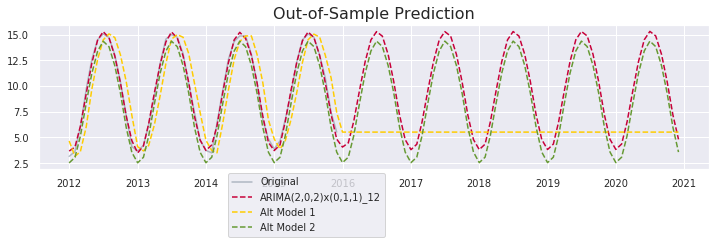

In [80]:


fig = plt.figure(figsize = (10, 4))
mod_names = ['ARIMA(2,0,2)x(0,1,1)_12', 'Alt Model 1', 'Alt Model 2']
predicts = [predict_mod202, predict_altmod1['forecast'], predict_altmod2['forecast']]
colors = ['#c70039', '#FFCC00', '#669933']

plt.plot(global_temp['LandAverageTemperature']['2012':'2020'], color = 'slategray', label = 'Original', alpha = 0.5)

for i in range(3):
    plt.plot(predicts[i]['2012':'2020'], color = colors[i], linestyle = '--', label = mod_names[i])

plt.title('Out-of-Sample Prediction', size = 16)
plt.legend(loc='lower center', bbox_to_anchor=(0.4, -0.5))
fig.tight_layout()
plt.show()



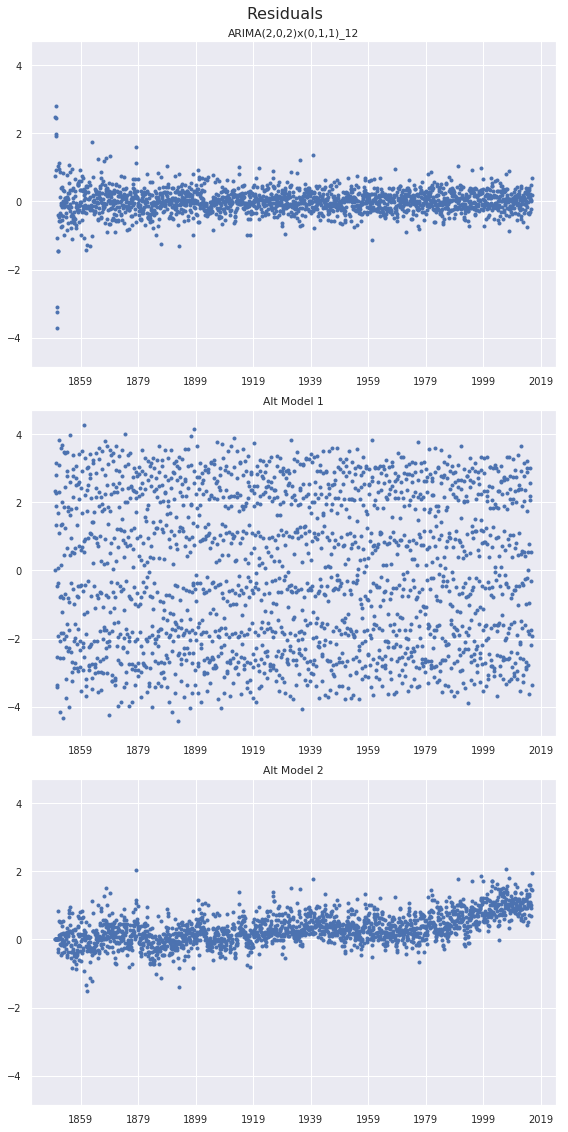

In [81]:
fig, axs = plt.subplots(3, sharey = True, figsize = (8, 16))
resids = [resid202, predict_altmod1['resid'].dropna(), predict_altmod2['resid'].dropna()]

for i in range(3):
    axs[i].set_title(mod_names[i])
    axs[i].plot(resids[i], 'b.')

fig.suptitle('Residuals', size = 16)
fig.tight_layout()
fig.subplots_adjust(top = 0.95)
plt.show()




We can see from the figures above that the Alt Model 1 (Persistence) has very scattered residuals (aka the errors are large). The residuals of Alt Model 2 (Overly Simplified Seasonal) seems to have a upward trend, which is undesirable.


ARIMA(2,0,2)x(0,1,1)_12 NormaltestResult(statistic=463.7759499276343, pvalue=1.9603429424634064e-101)
Alt Model 1 NormaltestResult(statistic=39154.27910224264, pvalue=0.0)
Alt Model 2 NormaltestResult(statistic=43.638821605600725, pvalue=3.3415678972000555e-10)


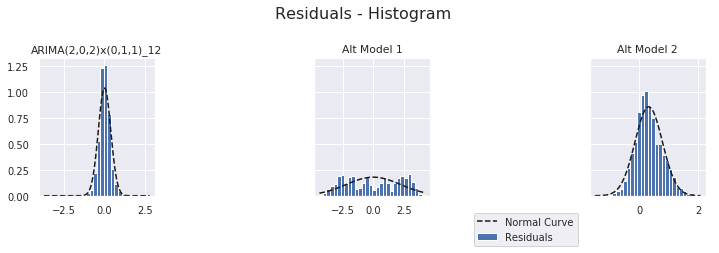

In [82]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (10, 4))

for i in range(3):
    plt.sca(axs[i])
    axs[i].set_title(mod_names[i])
    plt.hist(resids[i], bins = 30, normed = True, label = 'Residuals')
    
    x, y = fit_norm(resids[i])
    plt.plot(x, y,'k--', label = 'Normal Curve')
    
    print(mod_names[i], stats.normaltest(resids[i]))

fig.suptitle('Residuals - Histogram', size = 16)
plt.legend(loc='lower center', bbox_to_anchor=(-0.55, -0.4))
fig.tight_layout()
fig.subplots_adjust(top = 0.8)
plt.show()

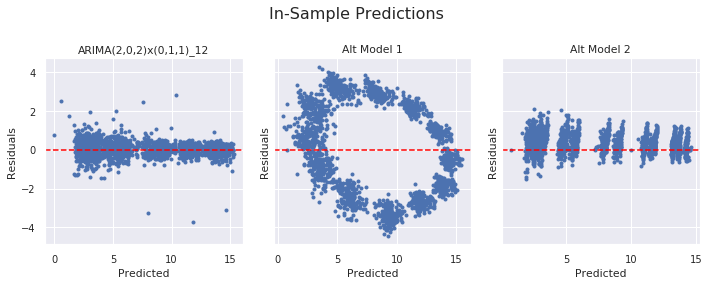

In [83]:
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (10, 4))

for i in range(3):
    plt.sca(axs[i])
    axs[i].set_title(mod_names[i])
    axs[i].set_xlabel('Predicted')
    axs[i].set_ylabel('Residuals')
    axs[i].plot(predicts[i][:'2015-12-01'], resids[i], 'b.')
    plt.axhline(y = 0, color='red', linestyle = '--')

fig.suptitle('In-Sample Predictions', size = 16)
fig.tight_layout()
fig.subplots_adjust(top = 0.8)
plt.show()



In the plots of the residuals against the fitted values above, we can see both of the alternative models showed patterns (again, undesirable), whereas the seasonal ARIMA model produced residuals scattered randomly around the line y = 0 (expected).


# Forecast Performance:




I will evaluate the forecast performance of these three model using two of the most commonly used measures, RMSE (root mean squared error) and MAE (mean absolute error).


In [85]:
print('{:<30s}{:<10s}{:<10s}'.format('Model', 'RMSE', 'MAE'))
print('-' * 50)

for i in range(3):
    print('{:<30s}{:<10.4f}{:<10.4f}'.format(mod_names[i], 
                                    sm.tools.eval_measures.rmse(global_temp['LandAverageTemperature'], 
                                                                predicts[i][:'2015-12-01']),
                                    sm.tools.eval_measures.meanabs(global_temp['LandAverageTemperature'], 
                                                                    predicts[i][:'2015-12-01'])))


Model                         RMSE      MAE       
--------------------------------------------------
ARIMA(2,0,2)x(0,1,1)_12       0.3831    0.2626    
Alt Model 1                   2.2259    1.9782    
Alt Model 2                   0.5635    0.4339    




Now we are confident that the seasonal ARIMA model out performs both of the baseline models.


In [63]:
import plotly
plotly.tools.set_credentials_file(username='harshini.chandak', api_key='wNubmOneaHwDIRLA0KFQ')

In [64]:
import plotly 
plotly.tools.set_config_file(world_readable=True,
                             sharing='public')

In [65]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import plotly.plotly as py
#py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

global_temp_country = pd.read_csv('GlobalLandTemperaturesByCountry.csv')




In [32]:
global_temp_country_clear = global_temp_country[~global_temp_country['Country'].isin(
    ['Denmark', 'Antarctica', 'France', 'Europe', 'Netherlands',
     'United Kingdom', 'Africa', 'South America'])]

global_temp_country_clear = global_temp_country_clear.replace(
   ['Denmark (Europe)', 'France (Europe)', 'Netherlands (Europe)', 'United Kingdom (Europe)'],
   ['Denmark', 'France', 'Netherlands', 'United Kingdom'])

Mapping of Average Temperatures of Countries in the worldmap

In [33]:
#finding average temperature of each country

countries = np.unique(global_temp_country_clear['Country'])
mean_temp = []
for country in countries:
    mean_temp.append(global_temp_country_clear[global_temp_country_clear['Country'] == 
                                               country]['AverageTemperature'].mean())
    
 

In [34]:
data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '', 
            title = '# Average\nTemperature,\n°C')
            )
       ]


In [35]:
layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        projection = dict(
        type = 'orthographic',
            rotation = dict(
                    lon = 60,
                    lat = 10),
        ),
        lonaxis =  dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
            ),
        lataxis = dict(
                showgrid = True,
                gridcolor = 'rgb(102, 102, 102)'
                )
            ),
        )

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='worldmap')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~harshini.chandak/0 or inside your plot.ly account where it is named 'worldmap'




It is possible to notice that Russia has one of the lowest average temperature (like a Canada). The lowest temperature in Greenland (it is distinctly visible on the map). The hottest country in Africa, on the equator. It is quite natural.

Sorting the Average Temperatures of Countries :

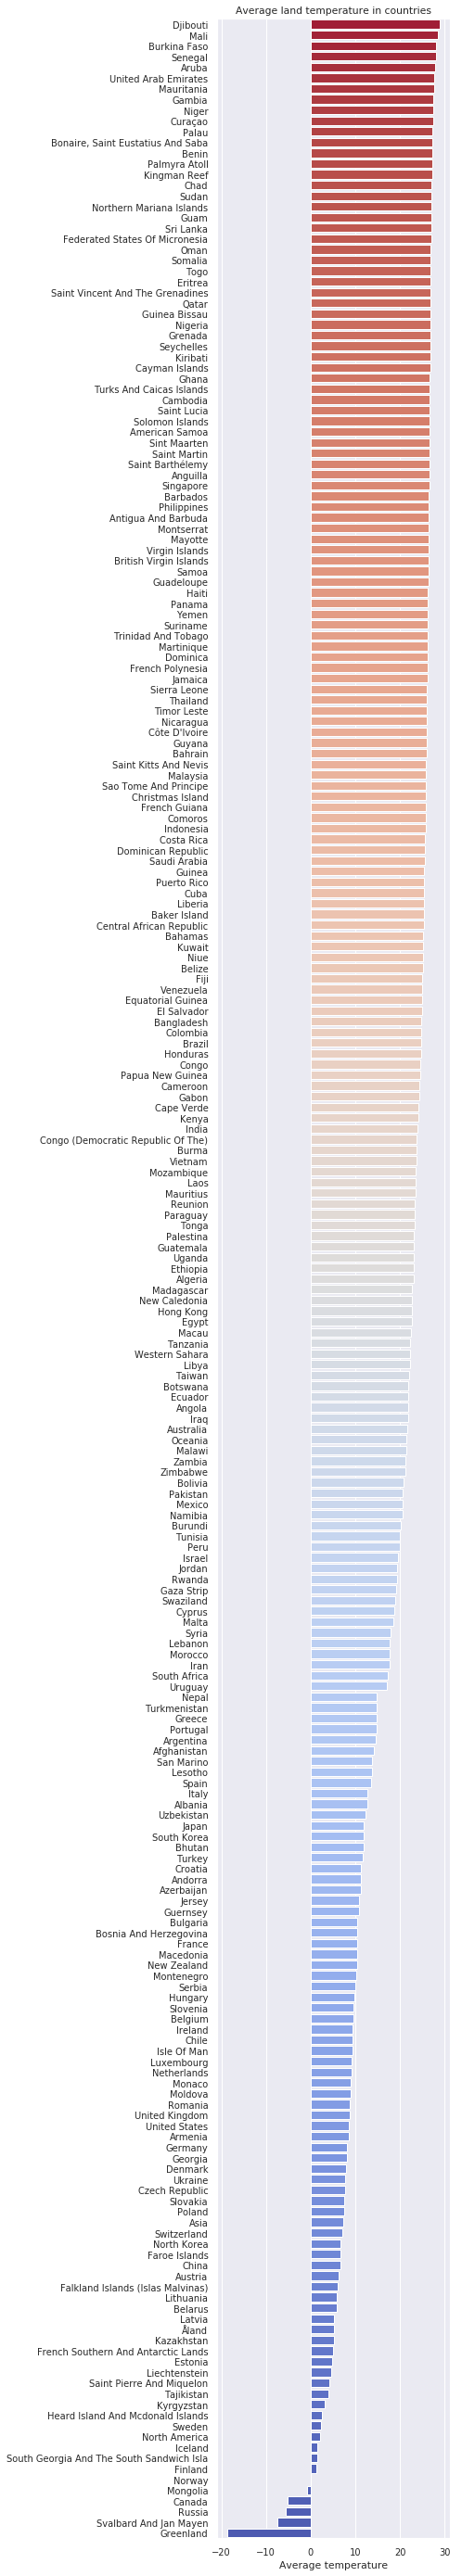

In [36]:

mean_temp_bar, countries_bar = (list(x) for x in zip(*sorted(zip(mean_temp, countries), 
                                                             reverse = True)))
sns.set(font_scale=0.9) 
f, ax = plt.subplots(figsize=(4.5, 50))
colors_cw = sns.color_palette('coolwarm', len(countries))
sns.barplot(mean_temp_bar, countries_bar, palette = colors_cw[::-1])
Text = ax.set(xlabel='Average temperature', title='Average land temperature in countries')

To Check If there is Global Warming:

In [37]:
global_temp = pd.read_csv("GlobalTemperatures.csv")

years = np.unique(global_temp['dt'].apply(lambda x: x[:4]))
mean_temp_world = []
mean_temp_world_uncertainty = []

for year in years:
    mean_temp_world.append(global_temp[global_temp['dt'].apply(
        lambda x: x[:4]) == year]['LandAverageTemperature'].mean())
    mean_temp_world_uncertainty.append(global_temp[global_temp['dt'].apply(
                lambda x: x[:4]) == year]['LandAverageTemperatureUncertainty'].mean())
  

In [38]:
trace0 = go.Scatter(
    x = years, 
    y = np.array(mean_temp_world) + np.array(mean_temp_world_uncertainty),
    fill= None,
    mode='lines',
    name='Uncertainty top',
    line=dict(
        color='rgb(0, 255, 255)',
    )
)
trace1 = go.Scatter(
    x = years, 
    y = np.array(mean_temp_world) - np.array(mean_temp_world_uncertainty),
    fill='tonexty',
    mode='lines',
    name='Uncertainty bot',
    line=dict(
        color='rgb(0, 255, 255)',
    )
)

trace2 = go.Scatter(
    x = years, 
    y = mean_temp_world,
    name='Average Temperature',
    line=dict(
        color='rgb(199, 121, 093)',
    )
)
data = [trace0, trace1, trace2]

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature in world',
    showlegend = False)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig)



From the charts we can see, that there is global warming nowadays. The average temperature of Earth surface has the highest value in the last three centuries. The fastest temperature growth occurred in the last 30 years! I hope soon humanity will fully switch to ecological sources of energy, that will reduce CO2. If this does not happen, we will be in disaster. This charts also have confidence intervals, which shows that measurement of temperature has become more accurate in the last few years.



Annual Temperature changes in certain countries:

In [39]:
continent = ['Russia', 'United States', 'Niger', 'Greenland', 'Australia', 'Bolivia']
mean_temp_year_country = [ [0] * len(years[70:]) for i in range(len(continent))]
j = 0
for country in continent:
    all_temp_country = global_temp_country_clear[global_temp_country_clear['Country'] == country]
    i = 0
    for year in years[70:]:
        mean_temp_year_country[j][i] = all_temp_country[all_temp_country['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperature'].mean()
        i +=1
    j += 1

traces = []
colors = ['rgb(0, 255, 255)', 'rgb(255, 0, 255)', 'rgb(0, 0, 0)',
          'rgb(255, 0, 0)', 'rgb(0, 255, 0)', 'rgb(0, 0, 255)']
for i in range(len(continent)):
    traces.append(go.Scatter(
        x=years[70:],
        y=mean_temp_year_country[i],
        mode='lines',
        name=continent[i],
        line=dict(color=colors[i]),
    ))

layout = go.Layout(
    xaxis=dict(title='year'),
    yaxis=dict(title='Average Temperature, °C'),
    title='Average land temperature on the continents',)

fig = go.Figure(data=traces, layout=layout)
py.iplot(fig)



We can see that since 1980 there has been a continuous increase in mean annual temperature for the countries, which we take into consideration (particularly strong dynamics can be seen in the cold countries). The interruption of the temperature values on the chart is due to the lack of observations in these years.


Dynamic Map:

In [40]:
years = np.unique(global_temp_country_clear['dt'].apply(lambda x: x[:4]))


mean_temp_year_country = [ [0] * len(countries) for i in range(len(years[::10]))]

j = 0
for country in countries:
    all_temp_country = global_temp_country_clear[global_temp_country_clear['Country'] == country]
    i = 0
    for year in years[::10]:
        mean_temp_year_country[i][j] = all_temp_country[all_temp_country['dt'].apply(
                lambda x: x[:4]) == year]['AverageTemperature'].mean()
        i +=1
    j += 1

In [66]:
stream_tokens = tls.get_credentials_file()['stream_ids']
print(stream_tokens)

[]


In [67]:
stream_tokens = tls.get_credentials_file()['stream_ids']
token =  stream_tokens[-1]
stream_id = dict(token=token, maxpoints=60)


data = [ dict(
        type = 'choropleth',
        locations = countries,
        z = mean_temp,
        locationmode = 'country names',
        text = countries,
        marker = dict(
            line = dict(color = 'rgb(0,0,0)', width = 1)),
            colorbar = dict(autotick = True, tickprefix = '',
            title = '# Average\nTemperature,\n°C'),       
        stream = stream_id
            )
       ]

layout = dict(
    title = 'Average land temperature in countries',
    geo = dict(
        showframe = False,
        showocean = True,
        oceancolor = 'rgb(0,255,255)',
        type = 'equirectangular'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig, validate=False, filename='world_temp_map')

IndexError: list index out of range

On the dynamic map we would have seen that the European countries started to measure temperature much more earlier than another countries. Perhaps this is due to more rapid economic development of the European countries in the 18th century. Russia and the United States began to measure the temperature only a half-century later.

In [43]:
"""s = py.Stream(stream_id=token)
i = 0
s.open()
while True:
    ye = years[::10]
    s.write(dict(z = mean_temp_year_country[i]), dict(
            title = 'Average land temperature in countries.   Year: {0}'.format(ye[i])), validate=False)
    time.sleep(1)
    i += 1
    if i == len(ye):
        i = 0
s.close()"""


"s = py.Stream(stream_id=token)\ni = 0\ns.open()\nwhile True:\n    ye = years[::10]\n    s.write(dict(z = mean_temp_year_country[i]), dict(\n            title = 'Average land temperature in countries.   Year: {0}'.format(ye[i])), validate=False)\n    time.sleep(1)\n    i += 1\n    if i == len(ye):\n        i = 0\ns.close()"

In [44]:
s = py.Stream(stream_id=token)
i = 0
s.open()
while True:
    ye = years[::10]
    s.write(dict(z = mean_temp_year_country[i]), dict(
            title = 'Average land temperature in countries.   Year: {0}'.format(ye[i])), validate=False)
    time.sleep(1)
    i += 1
    if i == len(ye):
        i = 0
s.close()


NameError: name 'token' is not defined

The results:




During my research ,I found that there has been a global increase trend in temperature, particularly over the last 30 years. This is due to the violent activities of a humankind. In more developed countries the temperature began to register much earlier. Over time the accuracy of the observations is increased, that is quite natural. Mankind must reflect and take all necessary remedies to reduce emissions of greenhouse gases in the atmosphere. 
